In [2]:
import pandas as pd
import os
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, results_path
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)


# Load the saved predictions
file_name = 'results_ResNet_all_runs.csv'

path = os.path.join(results_path, file_name)
df = pd.read_csv(path)
# df = pd.read_csv('results_ResNet_all_runs.csv')

def extract_base_record_id(window_id):
    return re.sub(r"-chan\d+-\d+$", "", window_id)
    df["base_record_id"] = df["window_id"].apply(extract_base_record_id)



Run 1 — Confusion Matrix:
[[ 63   5]
 [111 141]]
              precision    recall  f1-score   support

           0     0.3621    0.9265    0.5207        68
           1     0.9658    0.5595    0.7085       252

    accuracy                         0.6375       320
   macro avg     0.6639    0.7430    0.6146       320
weighted avg     0.8375    0.6375    0.6686       320


Run 2 — Confusion Matrix:
[[ 64   4]
 [115 137]]
              precision    recall  f1-score   support

           0     0.3575    0.9412    0.5182        68
           1     0.9716    0.5437    0.6972       252

    accuracy                         0.6281       320
   macro avg     0.6646    0.7424    0.6077       320
weighted avg     0.8411    0.6281    0.6592       320


Run 3 — Confusion Matrix:
[[ 65   3]
 [115 137]]
              precision    recall  f1-score   support

           0     0.3611    0.9559    0.5242        68
           1     0.9786    0.5437    0.6990       252

    accuracy                    

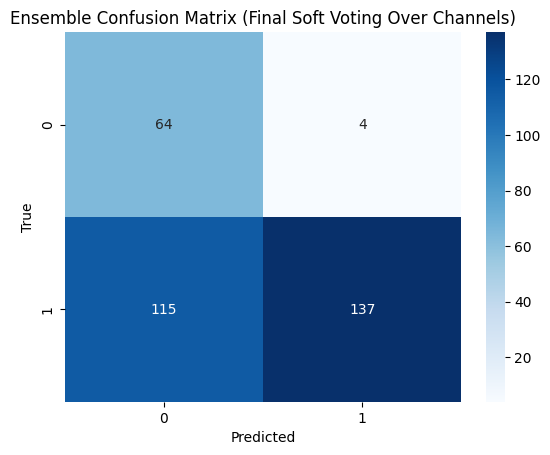

In [3]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Extract base_window_id (strip channel only)
df["base_window_id"] = df["window_id"].apply(lambda x: re.sub(r"-chan\d+", "", x))

# Identify run indices (assuming columns like 'pred_prob0', 'pred_prob1', ...)
run_indices = sorted(set(int(col.replace("pred_label", "")) for col in df.columns if col.startswith("pred_label")))

metrics_list = []
aggregated_probs_per_run = []

for i in run_indices:
    prob_col = f"pred_prob{i}"

    # ✅ Aggregate over channels (per base_window_id) via mean of probabilities
    aggregated = df.groupby("base_window_id").agg({
        prob_col: "mean",                      # soft vote over channels
        "target": lambda x: x.iloc[0]          # target is the same for all channels of the window
    }).reset_index()

    # Store for final aggregation
    aggregated_probs_per_run.append(aggregated.set_index("base_window_id")[prob_col])

    # Threshold to get predicted labels
    aggregated[f"pred_label{i}"] = (aggregated[prob_col] >= 0.5).astype(int)

    # Evaluate this run
    y_true = aggregated["target"].values
    y_pred = aggregated[f"pred_label{i}"].values
    y_prob = aggregated[prob_col].values

    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    try:
        ap = average_precision_score(y_true, y_prob)
    except ValueError:
        ap = np.nan

    metrics_list.append({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": auc,
        "ap": ap
    })
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nRun {i} — Confusion Matrix:")
    print(cm)
    print(classification_report(y_true, y_pred, digits=4))


# 📊 Metrics summary
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(f"\n📊 Aggregated Soft Voting Over Channels (Per Window) — {len(run_indices)} Runs:\n")
for metric in mean_metrics.index:
    print(f"{metric.capitalize():<10}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

# 🧮 Final soft voting across runs (mean of probs)
mean_probs = pd.concat(aggregated_probs_per_run, axis=1).mean(axis=1)
final_targets = df.groupby("base_window_id")["target"].first()

final_df = pd.DataFrame({
    "pred_prob": mean_probs,
    "target": final_targets
})
final_df["pred_label"] = (final_df["pred_prob"] >= 0.5).astype(int)

# 🧩 Final Confusion Matrix
y_true = final_df["target"].values
y_pred = final_df["pred_label"].values

cm = confusion_matrix(y_true, y_pred)
print("\n🧩 Confusion Matrix (Final Soft Voting Over Channels):")
print(cm)
print("\n📃 Classification Report (Final Soft Voting Over Channels):")
print(classification_report(y_true, y_pred, digits=4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix (Final Soft Voting Over Channels)')
plt.show()


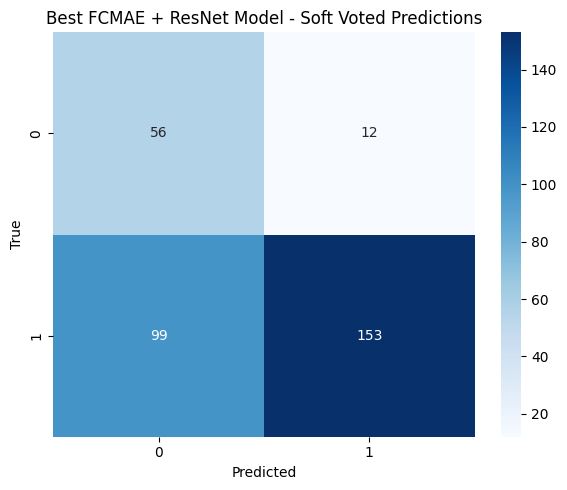

In [4]:
'''PLOTTING CONFUSION MATRICES'''

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
cm = np.array([[ 56, 12],
                 [ 99, 153]])

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1], yticklabels=[0, 1])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Best FCMAE + ResNet Model - Soft Voted Predictions')
plt.tight_layout()
plt.show()


 1. Channel-wise Accuracy (Majority Voting Per Channel)
Evaluate each channel's predictions independently by aggregating over all windows that belong to that channel, then compare with ground truth.

In [5]:
# import re
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import accuracy_score

# # Extract channel number from window_id (1-indexed)
# df["channel_id"] = df["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)) + 1)

# channel_stats = []

# for chan in sorted(df["channel_id"].unique()):
#     chan_df = df[df["channel_id"] == chan]
    
#     for i in run_indices:
#         prob_col = f"pred_prob{i}"
#         label_col = f"pred_label{i}"

#         chan_run_df = chan_df.copy()
#         chan_run_df["base_record_id"] = chan_run_df["window_id"].apply(
#             lambda x: re.sub(r"-chan\d+-\d+$", "", x)
#         )
        
#         # Aggregate by window
#         agg = chan_run_df.groupby("window_id").agg({
#             prob_col: "mean",
#             "target": lambda x: x.iloc[0]
#         }).reset_index()
        
#         agg["pred_label"] = (agg[prob_col] >= 0.5).astype(int)
        
#         acc = accuracy_score(agg["target"], agg["pred_label"])
        
#         channel_stats.append({
#             "channel": chan,  # Already 1-indexed
#             "run": i,
#             "accuracy": acc
#         })

# channel_stats_df = pd.DataFrame(channel_stats)

# # 📊 Summarize accuracy per channel
# channel_summary = channel_stats_df.groupby("channel")["accuracy"].agg(["mean", "std"]).reset_index()
# channel_summary = channel_summary.sort_values("mean", ascending=False)

# print("\n📈 Channel-wise Accuracy Across Runs:")
# print(channel_summary)

# # 📈 Plot
# plt.figure(figsize=(8, 5))
# x = channel_summary["channel"].astype(str)
# means = channel_summary["mean"]
# stds = channel_summary["std"]

# plt.bar(x, means, yerr=stds, capsize=5, color=plt.cm.viridis(np.linspace(0, 1, len(x))))
# plt.title("Average Accuracy Per Channel")
# plt.xlabel("Channel")
# plt.ylabel("Mean Accuracy")
# plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()


2. Channel Contribution to Correct Prediction (Voting Consistency)
For each window (across all channels), compute how often each channel votes the correct label (agreeing with the ground truth), and use this to get a sense of reliability:


✅ Correctness Rate Per Channel (Average over runs):
   channel_id      mean       std
0           1  0.645000  0.004739
3           4  0.638750  0.003563
1           2  0.636875  0.005590
4           5  0.631250  0.002210
2           3  0.626875  0.004739
5           6  0.625000  0.005413


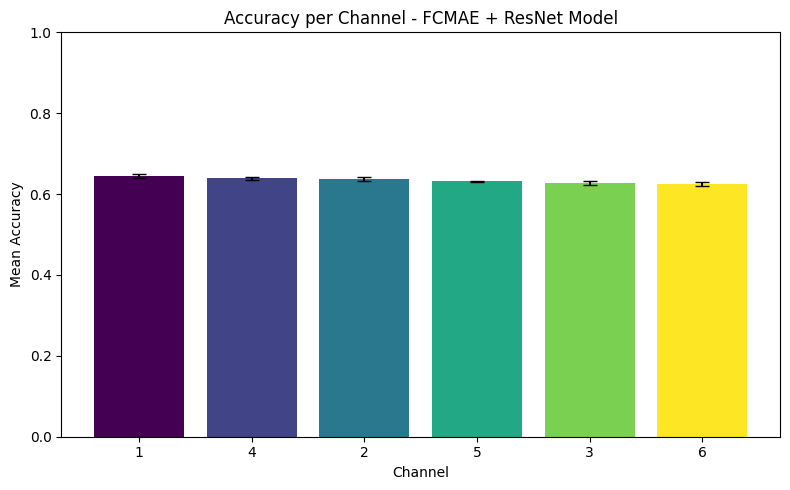

NameError: name 'pivot' is not defined

In [6]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add column with correct predictions per channel per run (1-indexed)
correct_per_channel = []

for i in run_indices:
    label_col = f"pred_label{i}"
    
    temp = df.copy()
    temp["channel_id"] = temp["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)) + 1)
    temp["correct"] = (temp[label_col] == temp["target"]).astype(int)
    
    stats = temp.groupby("channel_id")["correct"].mean().reset_index()
    stats["run"] = i
    correct_per_channel.append(stats)

correct_df = pd.concat(correct_per_channel)

# Summarize
correct_summary = correct_df.groupby("channel_id")["correct"].agg(["mean", "std"]).reset_index()
correct_summary = correct_summary.sort_values("mean", ascending=False)

print("\n✅ Correctness Rate Per Channel (Average over runs):")
print(correct_summary)

# 📈 Plot
plt.figure(figsize=(8, 5))

x = correct_summary["channel_id"].astype(str)
means = correct_summary["mean"]
stds = correct_summary["std"]

plt.bar(x, means, yerr=stds, capsize=5, color=plt.cm.viridis(np.linspace(0, 1, len(x))))

plt.title("Accuracy per Channel - FCMAE + ResNet Model")
plt.xlabel("Channel")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


from itertools import combinations
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

pairs = list(combinations(pivot.columns, 2))
p_values = []

for ch1, ch2 in pairs:
    stat, p = wilcoxon(pivot[ch1], pivot[ch2])
    p_values.append(p)

# Correct for multiple comparisons
rejected, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print results
for i, (ch1, ch2) in enumerate(pairs):
    print(f"{ch1} vs {ch2} → p = {p_corrected[i]:.4f} {'✅' if rejected[i] else '❌'}")


3. Channel Disagreement Analysis
Count how often each channel disagrees with the final soft-voted window label, which can show which channels are less aligned with the consensus.

In [26]:
# Assume final prediction per window is already computed (you can reuse your soft-voting logic)
# Here we'll assume you soft-voted over channels per window and got: final_window_preds_df
# It should have: window_id, final_pred_label, target

# Merge back channel-specific predictions
disagreement_stats = []

for i in run_indices:
    label_col = f"pred_label{i}"
    temp = df[["window_id", "target", label_col]].copy()
    temp = temp.rename(columns={label_col: "channel_pred"})
    temp["channel_id"] = temp["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)))

    # You should already have a DataFrame with final per-window predictions (after soft voting over channels)
    # For simplicity, recompute it quickly:
    final_pred_per_window = df.groupby("window_id")[f"pred_prob{i}"].mean().reset_index()
    final_pred_per_window["final_pred"] = (final_pred_per_window[f"pred_prob{i}"] >= 0.5).astype(int)

    merged = pd.merge(temp, final_pred_per_window[["window_id", "final_pred"]], on="window_id")

    merged["disagrees_with_final"] = (merged["channel_pred"] != merged["final_pred"]).astype(int)

    stat = merged.groupby("channel_id")["disagrees_with_final"].mean().reset_index()
    stat["run"] = i
    disagreement_stats.append(stat)

disagreement_df = pd.concat(disagreement_stats)

# Summarize
disagreement_summary = disagreement_df.groupby("channel_id")["disagrees_with_final"].agg(["mean", "std"]).reset_index()
disagreement_summary = disagreement_summary.sort_values("mean")

print("\n🤔 Channel Disagreement Rate with Final Prediction:")
print(disagreement_summary)



🤔 Channel Disagreement Rate with Final Prediction:
   channel_id  mean  std
0           0   0.0  0.0
1           1   0.0  0.0
2           2   0.0  0.0
3           3   0.0  0.0
4           4   0.0  0.0
5           5   0.0  0.0


4. Channel agreement analysis

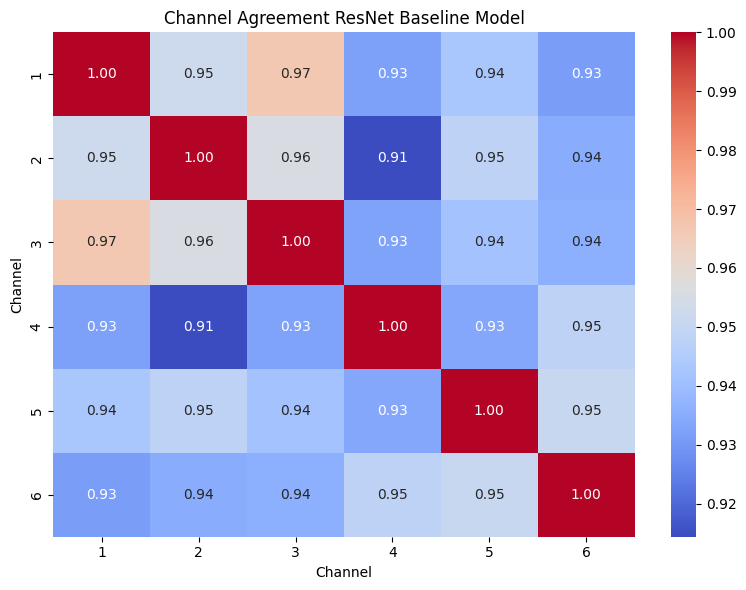

In [27]:
import seaborn as sns

# Initialize matrix to accumulate agreement counts
n_channels = df["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)) + 1).max()
agreement_matrix = np.zeros((n_channels, n_channels))

# For each run, compute pairwise agreement
for i in run_indices:
    label_col = f"pred_label{i}"
    
    temp = df[["window_id", label_col]].copy()
    temp["record_base"] = temp["window_id"].apply(lambda x: re.sub(r"-chan\d+", "", x))
    temp["channel"] = temp["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)))
    
    # Pivot to shape (n_windows_per_record, n_channels)
    pivot = temp.pivot(index="record_base", columns="channel", values=label_col)
    
    # Compute agreement between every pair of channels
    for c1 in range(n_channels):
        for c2 in range(n_channels):
            if c1 == c2:
                agreement = 1.0
            else:
                valid_mask = pivot[c1].notna() & pivot[c2].notna()
                agreement = (pivot[c1][valid_mask] == pivot[c2][valid_mask]).mean()
            agreement_matrix[c1, c2] += agreement

# Average across runs
agreement_matrix /= len(run_indices)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(1, n_channels+1), yticklabels=range(1, n_channels+1))
plt.title("Channel Agreement ResNet Baseline Model")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.tight_layout()
plt.show()


Statistical test voted vs. unvoted for FCMAE + ResNet


In [1]:
import pandas as pd
from scipy.stats import wilcoxon

# Voted performance (5 runs)
voted = pd.DataFrame({
    "accuracy":    [0.7875, 0.684375, 0.653125, 0.78125, 0.7875],
    "precision":   [0.7875, 0.908108, 0.927273, 0.786164, 0.792994],
    "recall":      [1.0, 0.666667, 0.607143, 0.992063, 0.988095],
    "f1":          [0.881119, 0.768879, 0.733813, 0.877193, 0.879859],
    "ap":          [0.839165, 0.894384, 0.908801, 0.922714, 0.898984],
    "auc":         [0.657505, 0.750817, 0.735119, 0.759395, 0.758695],
})

# Unvoted performance (5 runs)
unvoted = pd.DataFrame({
    "accuracy":    [0.790104, 0.677083, 0.636458, 0.777083, 0.785417],
    "precision":   [0.789556, 0.904719, 0.929325, 0.787076, 0.793803],
    "recall":      [1.0, 0.659392, 0.582672, 0.982804, 0.982804],
    "f1":          [0.882404, 0.762816, 0.716260, 0.874118, 0.878251],
    "ap":          [0.832993, 0.889820, 0.907746, 0.907664, 0.888388],
    "auc":         [0.610278, 0.730438, 0.723915, 0.737735, 0.721006],
})

# Wilcoxon test per metric
results = []
for col in voted.columns:
    stat, p = wilcoxon(voted[col], unvoted[col])
    results.append({
        "Metric": col,
        "Voted Mean": voted[col].mean(),
        "Unvoted Mean": unvoted[col].mean(),
        "p-value": p
    })

# Create results table
results_df = pd.DataFrame(results)
results_df["Significant"] = results_df["p-value"] < 0.05
print(results_df.to_string(index=False))


   Metric  Voted Mean  Unvoted Mean  p-value  Significant
 accuracy    0.738750      0.733229   0.1875        False
precision    0.840408      0.840896   0.6250        False
   recall    0.850794      0.841534   0.1250        False
       f1    0.828173      0.822770   0.1250        False
       ap    0.892810      0.885322   0.0625        False
      auc    0.732306      0.704674   0.0625        False


Statistical test voted vs. unvoted resnet baseline

In [7]:
# Re-defining the data since the previous code context was lost

import pandas as pd
from scipy.stats import wilcoxon

# Voted performance metrics for ResNet baseline
voted_data = pd.DataFrame({
    "accuracy": [0.637500, 0.628125, 0.631250, 0.628125, 0.628125],
    "precision": [0.965753, 0.971631, 0.978571, 0.978417, 0.965035],
    "recall": [0.559524, 0.543651, 0.543651, 0.539683, 0.547619],
    "f1": [0.708543, 0.697201, 0.698980, 0.695652, 0.698734],
    "roc_auc": [0.780054, 0.769199, 0.763597, 0.775794, 0.765523],
    "average_precision": [0.938154, 0.937345, 0.936005, 0.939223, 0.935960],
})

# Unvoted performance metrics for ResNet baseline
unvoted_data = pd.DataFrame({
    "accuracy": [0.6380208333333334, 0.6322916666666667, 0.6317708333333333, 0.6333333333333333, 0.634375],
    "precision": [0.9615819209039548, 0.9642857142857143, 0.9718640093786636, 0.9809523809523809, 0.9540358744394619],
    "recall": [0.5628306878306878, 0.5535714285714286, 0.5482804232804233, 0.544973544973545, 0.5628306878306878],
    "f1": [0.7100542344597414, 0.7033613445378152, 0.7010570824524313, 0.7006802721088435, 0.7079866888519135],
    "average_precision": [0.9292562411264144, 0.9299049185658371, 0.9295795673267802, 0.9314153453813555, 0.9289307971211604],
    "roc_auc": [0.7607254707438531, 0.7583498677248677, 0.7542422061417159, 0.7638305322128851, 0.7563560146280734],
})

# Perform Wilcoxon signed-rank test for each metric
results = []
for column in voted_data.columns:
    stat, p = wilcoxon(voted_data[column], unvoted_data[column])
    results.append({
        "Metric": column,
        "Voted Mean": voted_data[column].mean(),
        "Unvoted Mean": unvoted_data[column].mean(),
        "p-value": round(p, 4),
        "Significant": p < 0.05
    })

resnet_results_df = pd.DataFrame(results)
resnet_results_df


,Metric,Voted Mean,Unvoted Mean,p-value,Significant
0,accuracy,0.630625,0.633958,0.0625,False
1,precision,0.971881,0.966544,0.1250,False
2,recall,0.546826,0.554497,0.0625,False
3,f1,0.699822,0.704628,0.0625,False
4,roc_auc,0.770833,0.758701,0.0625,False
5,average_precision,0.937337,0.929817,0.0625,False
